# YRoration (YGate) - Keras Tuner

## Configuration

Pulse and fidelity computation are computation intensive (slow).

In [1]:
PULSE_ENABLED = False
FIDELITY_ENABLED = True
RANDOM_SEARCH_ENABLED = False
BAYESIAN_OPTIMIZATION_ENABLED = True
HYPERBAND_ENABLED = False

Parameters are stored in a shared script.

In [2]:
from parameters import *

Enable seeding for reproducibility of the training.

## Library

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_sequential_ascii import keras2ascii
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('..')

from utils.helpers import *

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-04-08 16:14:48.927105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Check GPU

## Dataset

### Load

In [4]:
x_train = np.load('./data/yrotation/{}/x_train.npy'.format(CSV_CONFIG))
x_val = np.load('./data/yrotation/{}/x_val.npy'.format(CSV_CONFIG))
x_test = np.load('./data/yrotation/{}/x_test.npy'.format(CSV_CONFIG))
y_train = np.load('./data/yrotation/{}/y_train.npy'.format(CSV_CONFIG))
y_val = np.load('./data/yrotation/{}/y_val.npy'.format(CSV_CONFIG))
y_test = np.load('./data/yrotation/{}/y_test.npy'.format(CSV_CONFIG))

In [5]:
N_ANGLES = x_train.shape[1]
N_PARAMS = y_train.shape[1]

In [6]:
print('---------------------------------------')
print('- Pulse parameters (y) #', N_PARAMS) # ASSUMING 1 BETA VALUE (ANGLE ALONG Y AXIS)
print('- Gate parameters  (x) #', N_ANGLES) # ASSUMING 1 BETA VALUE (ANGLES ALONG Y AXIS)
print('---------------------------------------')

---------------------------------------
- Pulse parameters (y) # 20
- Gate parameters  (x) # 1
---------------------------------------


### Evaluation

<span style="color:red">ATTENTION: Measuring fidelity on the entire train, validation, and test sets could be time consuming. Use `limit` parameter in case.</span>

### Keras Tuner

In [7]:
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

In [8]:
def sine_activation(x):
    return tf.math.sin(x)

def build_model(hp):
    model = Sequential()
    # Input layer
    model.add(Input(shape=(1,)))
    # N dense +  layers
    for i in range(hp.Int('layers', 1, 7)):
        model.add(
            tf.keras.layers.Dense(
                units = hp.Int('units_' + str(i), 8, 16, step = 4),
                name = 'fc' + str(i)
            )
        )
        #dropout = hp.Boolean("dropout_" + str(i))
        #if dropout:
        #    model.add(keras.layers.Dropout(rate = 0.25))
        #batchnorm = hp.Boolean("batchnorm_" + str(i))
        #if batchnorm:
        #    model.add(keras.layers.BatchNormalization(name = 'batchnorm_' + str(i)))
        model.add(Activation(activation = sine_activation, name = 'sine' + str(i)))
    # Dense layer
    model.add(Dense(units = 20, name = 'fc_last'))
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer = tf.optimizers.Adam(learning_rate = learning_rate),
        loss = tf.losses.MeanSquaredError(),
        metrics = [   'mean_squared_error'
                      #, tf.metrics.MeanSquaredLogarithmicError()
                      #, tf.metrics.MeanAbsolutePercentageError()
                  ])
    return model

In [9]:
def slice_data(data, frac):
    return data[:int(data.shape[0]/frac)]

#### Random Search

In [10]:
if RANDOM_SEARCH_ENABLED:
    !rm -rf keras_tuner_random_search
    tuner = RandomSearch(
        build_model,
        objective = 'mean_squared_error',#tf.losses.MeanSquaredError(),
        max_trials = 30,
        executions_per_trial = 5,
        directory = 'keras_tuner_random_search'
    )

In [11]:
if RANDOM_SEARCH_ENABLED:
    tuner.search_space_summary()

In [12]:
if RANDOM_SEARCH_ENABLED:
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=50,
        verbose=1)
    tuner.search(slice_data(x_train, 1),
                 slice_data(y_train, 1),
                 epochs = 700,
                 batch_size = 128,
                 callbacks=[early_stopping],
                 validation_data = (slice_data(x_val, 1), slice_data(y_val, 1)),
                 verbose=0)
    tuner.results_summary()

In [13]:
if RANDOM_SEARCH_ENABLED:
    best_model = tuner.get_best_models()[0]

In [39]:
if RANDOM_SEARCH_ENABLED:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    #model = build_model(best_hps[0])

In [15]:
if RANDOM_SEARCH_ENABLED:
    model = best_model
    model.summary()

In [16]:
if RANDOM_SEARCH_ENABLED:
    keras2ascii(model)

In [17]:
if RANDOM_SEARCH_ENABLED:
    model_id = 'ktrs_MLP_' + get_basic_id(model)
    print(model_id)

#### Bayesian Optimization

In [18]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    !rm -rf keras_tuner_baesian_optimization
    tuner = BayesianOptimization(
        build_model,
        objective = 'mean_squared_error',
        max_trials = 30,
        executions_per_trial = 5,
        directory = 'keras_tuner_baesian_optimization'   
    )

2023-04-08 16:14:50.456599: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-08 16:14:50.463207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2023-04-08 16:14:50.463239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-08 16:14:50.465169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-08 16:14:50.465232: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-04-08 16:14:50.465935: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.

In [19]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    tuner.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 7, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 4, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [20]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=50,
        verbose=1)
    tuner.search(slice_data(x_train, 1),
             slice_data(y_train, 1),
             epochs = 700,
             batch_size = 128,
             validation_data = (slice_data(x_val, 1), slice_data(y_val, 1)),
             use_multiprocessing=True,
             callbacks=[early_stopping],
             workers=6,
             verbose=0)
    tuner.results_summary()

2023-04-08 16:14:50.666116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 00040: early stopping
Epoch 00046: early stopping
Epoch 00038: early stopping
Epoch 00044: early stopping
INFO:tensorflow:Oracle triggered exit
Results summary
Results in keras_tuner_baesian_optimization/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 5
units_0: 8
lr: 0.003470122933931012
units_1: 12
units_2: 8
units_3: 8
units_4: 8
Score: 6.69008932163706e-07
Trial summary
Hyperparameters:
layers: 4
units_0: 8
lr: 0.006423922543610202
units_1: 8
units_2: 8
units_3: 8
Score: 1.0947220175694382e-06
Trial summary
Hyperparameters:
layers: 4
units_0: 16
lr: 0.005660954003146256
units_1: 16
units_2: 16
units_3: 16
units_4: 8
Score: 1.3821500033373013e-06
Trial summary
Hyperparameters:
layers: 1
units_0: 12
lr: 0.00022811043437293685
units_1: 8
units_2: 16
units_3: 8
Score: 1.4929504231986358e-06
Trial summary
Hyperparameters:
layers: 1
units_0: 16
lr: 0.0032769995648111627
Score: 1.5653277387173148e-06


In [21]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    best_model = tuner.get_best_models()[0]

In [42]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    #model = build_model(best_hps[0])

In [23]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    model = best_model
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc0 (Dense)                  (None, 8)                 16        
_________________________________________________________________
sine0 (Activation)           (None, 8)                 0         
_________________________________________________________________
fc1 (Dense)                  (None, 12)                108       
_________________________________________________________________
sine1 (Activation)           (None, 12)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 8)                 104       
_________________________________________________________________
sine2 (Activation)           (None, 8)                 0         
_________________________________________________________________
fc3 (Dense)                  (None, 8)                 7

In [24]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           1
               Dense   XXXXX -------------------        16     2.9%
     sine_activation   #####           8
               Dense   XXXXX -------------------       108    19.6%
     sine_activation   #####          12
               Dense   XXXXX -------------------       104    18.8%
     sine_activation   #####           8
               Dense   XXXXX -------------------        72    13.0%
     sine_activation   #####           8
               Dense   XXXXX -------------------        72    13.0%
     sine_activation   #####           8
               Dense   XXXXX -------------------       180    32.6%
                       #####          20


In [25]:
if BAYESIAN_OPTIMIZATION_ENABLED:
    model_id = 'ktbo_MLP_' + get_basic_id(model)
    print(model_id)

ktbo_MLP_1x8x12x8x8x8x20


#### Hyperband

In [26]:
if HYPERBAND_ENABLED:
    !rm -rf keras_tuner_hyperband
    tuner = Hyperband(
        build_model,
        objective = 'val_loss',
        max_epochs = 50,
        executions_per_trial = 5,
        directory = 'keras_tuner_hyperband'
    )

In [27]:
if HYPERBAND_ENABLED:
    tuner.search_space_summary()

In [28]:
if HYPERBAND_ENABLED:
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=50,
        verbose=1)
    tuner.search(slice_data(x_train, 1),
                 slice_data(y_train, 1),
                 epochs = 700,
                 batch_size = 128,
                 validation_data = (slice_data(x_val, 1), slice_data(y_val, 1)),
                 use_multiprocessing=True,
                 callbacks=[early_stopping],
                 workers=6,
                 verbose=0)
    tuner.results_summary()

In [29]:
if HYPERBAND_ENABLED:
    best_model = tuner.get_best_models()[0]

In [40]:
if HYPERBAND_ENABLED:
    get_best_hyperparameters(num_trials=1)[0]
    #1model = build_model(best_hps[0])

In [31]:
if HYPERBAND_ENABLED:
    model = best_model
    model.summary()

In [32]:
if HYPERBAND_ENABLED:
    keras2ascii(model)

In [33]:
if HYPERBAND_ENABLED:
    model_id = 'kthb_MLP_' + get_basic_id(model)
    print(model_id)

### Training

In [34]:
best_model_file = PREFIX + '/best_keras_model.h5'
last_model_file = PREFIX + '/last_keras_model.h5'

Enable training (`train_and_save`) to overwrite the model file.

In [35]:
train_and_save = True

In [43]:
print(best_hps.get('lr'))

0.003470122933931012


In [44]:
model.compile(optimizer=tf.optimizers.Adam(lr=best_hps.get('lr')),
              loss=tf.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])

In [ ]:
%%time
history = None
if train_and_save:
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=30,
        verbose=1)
    model_checkpoint = ModelCheckpoint(
        filepath=best_model_file,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    history = model.fit(
        x_train,
        y_train,
        epochs=5000,
        batch_size=128, # default 32
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1)
    model.save(last_model_file)

Load the saved best model and use it from now on.

In [ ]:
model = load_model(best_model_file, custom_objects={'sine_activation': sine_activation})

### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Measure and print metrics.

In [ ]:
#mse, msle, mape = model.evaluate(x_test, y_test)
mse = model.evaluate(x_test, y_test)[0]
msle, mape = None, None

16384/16384 [==============================] - 6s 344us/step - loss: 3.2160e-07 - mean_squared_error: 3.2160e-07


In [ ]:
mse = model.evaluate(x_val, y_val)[0]
msle, mape = None, None

4096/4096 [==============================] - 1s 350us/step - loss: 3.1676e-07 - mean_squared_error: 3.1676e-07


In [ ]:
y_keras = model.predict(x_test)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc0 (Dense)                  (None, 8)                 16        
_________________________________________________________________
sine0 (Activation)           (None, 8)                 0         
_________________________________________________________________
fc1 (Dense)                  (None, 12)                108       
_________________________________________________________________
sine1 (Activation)           (None, 12)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 8)                 104       
_________________________________________________________________
sine2 (Activation)           (None, 8)                 0         
_________________________________________________________________
fc3 (Dense)                  (None, 8)                 7

Plot animation of a sorted test set along with its predictions

In [58]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt

# Sort the test values by beta

XY_actual = np.concatenate((x_test, y_test), axis=1)
XY_pred = np.concatenate((x_test, y_keras), axis=1)

#XY_actual = sort_array(XY_actual)
#XY_pred = sort_array(XY_pred)

XY_actual = XY_actual[XY_actual[:,0].argsort()]

XY_pred = XY_pred[XY_pred[:,0].argsort()]

#print(XY_actual)
#print(XY_pred)

## Needs ffmpeg. Install using "conda install -c conda-forge ffmpeg"
start_idx = x_test.shape[0]-2100
num_frames = 500
frame_interval_ms = 100

# get x and y
x = np.arange(1, N_PARAMS+1, 1)
#y = y_test[start_idx:start_idx+num_frames,:]
#y_pred = y_keras[start_idx:start_idx+num_frames,:]
#beta = x_test[start_idx:start_idx+num_frames,:]
y = XY_actual[start_idx:start_idx+num_frames,N_ANGLES:]
beta = XY_actual[start_idx:start_idx+num_frames,:N_ANGLES]
y_pred = XY_pred[start_idx:start_idx+num_frames,N_ANGLES:]

print(y.shape)
print(beta.shape)
print(y_pred.shape)

# create a figure and an axis object
plt.ioff()
fig, ax = plt.subplots()

# set labels and plot limits
plt.ylabel('Pulse parameter values')
plt.xlabel('Pulse parameters (α[1:{}])'.format(N_PARAMS))
#plt.ylim([min_pparam_value, max_pparam_value*5/4])
plt.xticks(x, x)

# initialize an empty line object
line, = ax.plot([], [], marker='o', linestyle='--', color='r', label='actual')
line_pr, = ax.plot([], [], marker='o', linestyle='--', color='g', label='predicted')
ax.legend()

# create a text object inside the axes
title = ax.text(0.05, 0.9, "", transform=ax.transAxes)

# define a function that updates the line object for each frame
def animate(i):
    title.set_text(f"Beta: {beta[i]}")
    # update line data
    line.set_data(x, y[i])
    line_pr.set_data(x, y_pred[i])
    return line,

# create an animation object using FuncAnimation
anim = animation.FuncAnimation(fig, animate,
                              frames=num_frames,
                              interval=frame_interval_ms,
                              repeat=False)

# show the animation
%matplotlib inline
HTML(anim.to_html5_video())

(500, 20)
(500, 1)
(500, 20)


23769


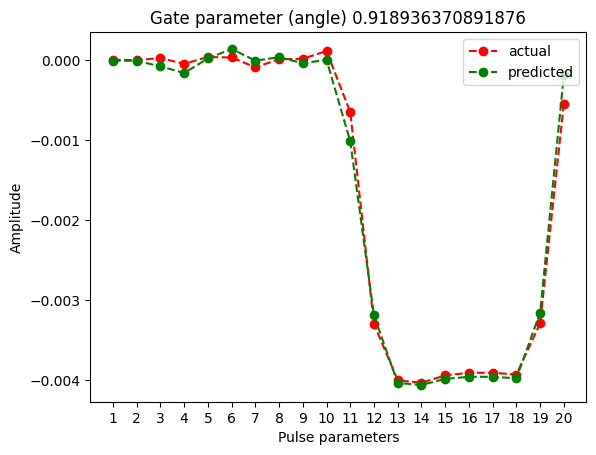

In [52]:
## Added Code to check visually the difference in signals from the model and the actual sample

%matplotlib inline
import matplotlib.pyplot as plt
    
entry_id = 0
outside = 0

x_new = []
y_new = []
while (entry_id < x_test.shape[0]):
    angle = x_test[entry_id:entry_id+1][0][0]
    if (angle > 3 or angle < -3):
        outside += 1
    else:
        x_new.append(x_test[entry_id])
        y_new.append(y_keras[entry_id])
    entry_id += 1
entry_id -= 1
x_new = np.array(x_new)
y_new = np.array(y_new)
print(outside)
x = np.arange(1, N_PARAMS+1, 1)
y = y_test[entry_id:entry_id+1,:N_PARAMS][0]
y_pr = y_keras[entry_id:entry_id+1,:N_PARAMS][0]

plt.plot(x, y, marker='o', linestyle='--', color='r', label='actual') 
plt.plot(x, y_pr, marker='o', linestyle='--', color='g', label='predicted') 
plt.legend(loc="upper right")
plt.xticks(x, x)
angle = x_test[entry_id:entry_id+1][0][0]
plt.title('Gate parameter (angle) {}'.format(angle))
plt.ylabel('Amplitude')
plt.xlabel('Pulse parameters')
plt.show()

In [53]:
import random
hash_id = random.getrandbits(32)

if FIDELITY_ENABLED:
    ygate_fidelity_keras = get_ygate_fidelity(x_test, y_keras,
    #ygate_fidelity_keras = get_ygate_fidelity(x_new, y_new,
                                              limit=x_test.shape[0],
                                              #limit=1000,
                                              config_template=CONFIG_TEMPLATE_JSON,
                                              pulse_data_path='/tmp/ygate_{:x}.csv'.format(hash_id),
                                              output_objf_path='/tmp/ygate_fidelity_{:x}.csv'.format(hash_id))
else:
    ygate_fidelity_keras = None

0


Save metrics values to file for future reference.

In [54]:
metrics_filename = PREFIX + '/metrics.csv'

# You can disable the writing if necessary.
write_metrics_csv = True

In [55]:
from utils.metrics import write_metrics
if write_metrics_csv:
    write_metrics(metrics_filename, 'Keras', model_id, mse, msle, mape, ygate_fidelity_keras)

In [56]:
from utils.metrics import print_metrics
print_metrics(metrics_filename)

,Date,Framework,ID,MSE,MSLE,MAPE,Fidelity
0,26/03/2023 15:27:33,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000000107501,NaN,NaN,0.999813338642
1,26/03/2023 16:27:23,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000000144451,NaN,NaN,0.999521928451
2,26/03/2023 16:47:38,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000000159653,NaN,NaN,0.999262346996
3,26/03/2023 17:00:03,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000002238557,NaN,NaN,0.967716975306
4,26/03/2023 17:15:21,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000022899336,NaN,NaN,0.500383998067
5,26/03/2023 17:33:17,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000003620726,NaN,NaN,0.973792933780
6,26/03/2023 18:30:53,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000000458110,NaN,NaN,0.992171543583
7,26/03/2023 18:44:26,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000001081720,NaN,NaN,0.999109099766
8,26/03/2023 19:31:18,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000000128790,NaN,NaN,0.999283289804
9,26/03/2023 19:52:43,Keras,largeMLP_1x128x128x128x128x128x128x128x128x20,0.000001256145,NaN,NaN,0.999979858363
